<a href="https://colab.research.google.com/github/asra020601/img--style/blob/main/img_%3E_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LIBRARIES AND DATASETS

In [ ]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.1/205.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
 

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import scipy.stats as stats
import argparse
import os
import torch
import torch.nn as nn
import torch.utils.data as data
from PIL import Image
from PIL import ImageFile
from tqdm import tqdm
from pathlib import Path
from torchvision import transforms
import copy
from typing import Optional, List
import torch
import torch.nn.functional as F
from torch import nn, Tensor
import numpy as np
import os
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files

# Upload the zip file
uploaded = files.upload()


Saving sample_content.zip to sample_content.zip


In [ ]:
from datasets import load_dataset
ds = load_dataset("Artificio/WikiArt") #this is the style dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/663 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

(…)-00000-of-00004-3c65976b59bc0ab4.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

(…)-00001-of-00004-441bd829579dead0.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

(…)-00002-of-00004-7b0bbb36fb350222.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

(…)-00003-of-00004-971fec8ddd44fece.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103250 [00:00<?, ? examples/s]

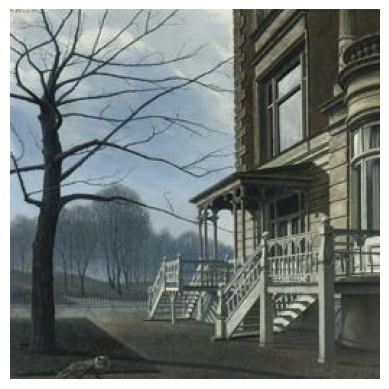

In [ ]:
# Select 10 random samples from the dataset
sampled_data = ds["train"].shuffle(seed=42).select(range(10))

# Display one of the images
image_example = sampled_data[0]["image"]
plt.imshow(image_example)
plt.axis("off")
plt.show()


# DATALOADER


In [ ]:
import torch
from torchvision import transforms

def dataset_to_4d_tensor(dataset, key="image"):
    """
    Convert a dataset of dictionaries containing PIL images into a 4D tensor (B, C, H, W).

    Args:
        dataset: List of dictionaries containing image data under a specific key.
        key: Key in the dictionaries where the image (PIL.Image) is stored.

    Returns:
        A 4D tensor of shape (B, C, H, W).
    """
    # Transformation to convert PIL image to PyTorch tensor
    to_tensor = transforms.ToTensor()

    # Convert each image in the dataset to a tensor
    image_tensors = [to_tensor(data[key]) for data in dataset]

    # Stack tensors into a batch
    return torch.stack(image_tensors)

# Example usage
batched_tensor = dataset_to_4d_tensor(sampled_data, key="image")
print(batched_tensor.shape)  # Should be (10, 3, 256, 256)


torch.Size([10, 3, 256, 256])


# PATCH EMBEDDINGS


## helper funcs

In [ ]:
from itertools import repeat
from collections.abc import Iterable
def _ntuple(n):
    def parse(x):
        if isinstance(x, Iterable):
            return x
        return tuple(repeat(x, n))
    return parse
to_2tuple = _ntuple(2)

# main embed class

In [ ]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=256, patch_size=8, in_chans=3, embed_dim=512):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)

        return x

In [ ]:
embed_style_patches = PatchEmbed(batched_tensor)
print(embed_style_patches)

PatchEmbed(
  (proj): Conv2d(3, 512, kernel_size=(8, 8), stride=(8, 8))
  (up1): Upsample(scale_factor=2.0, mode='nearest')
)


In [ ]:
# Assuming PatchEmbed is already defined
patch_embed = PatchEmbed(img_size=256, patch_size=8, in_chans=3, embed_dim=512)

# Example input: batch of 2 RGB images of size 256x256
input_tensor = batched_tensor  # Shape (B, C, H, W)

# Get output from PatchEmbed
patch_embed_output = patch_embed(input_tensor)  # Forward pass

In [ ]:
patch_embed_output.shape


torch.Size([10, 512, 32, 32])

# ENCODER


## helper funcs


In [ ]:
def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(F"activation should be relu/gelu, not {activation}.")

In [ ]:
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [ ]:
def prepare_for_transformer(patch_embed_output):
    """
    Convert the output of PatchEmbed to match the input shape of TransformerEncoderLayer.

    Args:
        patch_embed_output: A 4D tensor of shape (B, C, H_out, W_out).

    Returns:
        A 3D tensor of shape (S, B, d_model) where S = H_out * W_out and d_model = C.
    """
    B, C, H_out, W_out = patch_embed_output.shape  # Extract dimensions
    S = H_out * W_out  # Sequence length
    patch_embed_output = patch_embed_output.flatten(2)  # Flatten H_out and W_out -> (B, C, S)
    patch_embed_output = patch_embed_output.permute(2, 0, 1)  # Rearrange to (S, B, C)
    return patch_embed_output

## encoder layer and encoder

In [ ]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self,
                     src,
                     src_mask: Optional[Tensor] = None,
                     src_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None):
        q = k = self.with_pos_embed(src, pos)
        # q = k = src
        # print(q.size(),k.size(),src.size())
        src2 = self.self_attn(q, k, value=src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(self, src,
                    src_mask: Optional[Tensor] = None,
                    src_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(q, k, value=src2, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(self, src,
                src_mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


In [ ]:
# Get the embedding dimension (d_model) from the patch_embed_output shape
d_model = patch_embed_output.shape[1]  # d_model is the second dimension

# Create the TransformerEncoderLayer with the correct d_model value
encoder_layer = TransformerEncoderLayer(d_model, nhead=8)

# Prepare the input for the TransformerEncoderLayer
prepared_input = prepare_for_transformer(patch_embed_output)

# Now you can use the encoder_layer with the prepared_input
# For example:
output_s = encoder_layer(prepared_input)

In [ ]:
output_s.shape

torch.Size([1024, 10, 512])

In [ ]:
class TransformerEncoder(nn.Module):

    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src,
                mask: Optional[Tensor] = None,
                src_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None):
        output = src

        for layer in self.layers:
            output = layer(output, src_mask=mask,
                           src_key_padding_mask=src_key_padding_mask, pos=pos)

        if self.norm is not None:
            output = self.norm(output)

        return output

In [ ]:
# Get the embedding dimension (d_model) from the patch_embed_output shape
d_model = patch_embed_output.shape[1]  # d_model is the second dimension

# Create the TransformerEncoder with the correct d_model value
encoder_style = TransformerEncoder(encoder_layer, num_layers=3)

# Prepare the input for the TransformerEncoder
prepared_input = prepare_for_transformer(patch_embed_output)

# Now you can use the encoder with the prepared_input
# For example:
outputs = encoder_style(prepared_input)

In [ ]:
outputs.shape

torch.Size([1024, 10, 512])

# UPLOADING THE CONTENT DATASET

In [ ]:
import zipfile
import os
from PIL import Image

# Step 1: Extract ZIP file
zip_file_path = "/content/sample_content.zip"  # Path to your ZIP file
extract_path = "extracted_images"  # Directory to store extracted images

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Images extracted to: {extract_path}")

# Step 2: Process the images
output_path = "dataset_images"  # Directory for the dataset
os.makedirs(output_path, exist_ok=True)

image_count = 0  # Counter for images
target_size = (256, 256)  # Resize to a uniform size (optional)

for root, _, files in os.walk(extract_path):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
            image_path = os.path.join(root, file)
            try:
                # Open the image
                with Image.open(image_path) as img:
                    # Resize the image
                    img_resized = img.resize(target_size)
                    # Save the image to the dataset folder
                    output_file = os.path.join(output_path, f"image_{image_count + 1}.png")
                    img_resized.save(output_file)
                    image_count += 1
                    print(f"Processed and saved: {output_file}")

                    # Stop after 10 images
                    if image_count >= 10:
                        break
            except Exception as e:
                print(f"Error processing {file}: {e}")

    if image_count >= 10:
        break

print(f"Dataset created with {image_count} images at: {output_path}")



Images extracted to: extracted_images
Processed and saved: dataset_images/image_1.png
Processed and saved: dataset_images/image_2.png
Processed and saved: dataset_images/image_3.png
Processed and saved: dataset_images/image_4.png
Processed and saved: dataset_images/image_5.png
Processed and saved: dataset_images/image_6.png
Processed and saved: dataset_images/image_7.png
Processed and saved: dataset_images/image_8.png
Processed and saved: dataset_images/image_9.png
Processed and saved: dataset_images/image_10.png
Dataset created with 10 images at: dataset_images


In [ ]:
# prompt: change the 3 channels to 512  for batched_tensor from dataset_images

# ... (Your existing code)

# Modify the dataset_to_4d_tensor function to handle 512 channels
def dataset_to_4d_tensor(dataset):
    """
    Convert a dataset of PIL images into a 4D tensor (B, C, H, W),
    with 512 channels.  Pads or truncates the channels as needed.
    """
    to_tensor = transforms.ToTensor()
    image_tensors = []
    for data in dataset:
        tensor = to_tensor(data['image'])
        # Pad or truncate to 512 channels
        if tensor.shape[0] < 512:
            padding = torch.zeros(512 - tensor.shape[0], tensor.shape[1], tensor.shape[2])
            tensor = torch.cat([tensor, padding], dim=0)
        elif tensor.shape[0] > 512:
            tensor = tensor[:512, :, :]
        image_tensors.append(tensor)

    return torch.stack(image_tensors)

# Convert the dataset into a 4D tensor with 512 channels
batched_tensor = dataset_to_4d_tensor(dataset_images)

# Print the shape of the resulting tensor
print(f"Batched tensor shape: {batched_tensor.shape}")  # Should be (10, 512, 256, 256)


Batched tensor shape: torch.Size([10, 512, 256, 256])


In [ ]:
# prompt: delete all the folders except dataset_images

import shutil
import os

# Specify the directory to clean up
root_dir = "/content"

# Specify the folder to keep
folder_to_keep = "dataset_images"

# Walk through the directory
for dirpath, dirnames, filenames in os.walk(root_dir):
  for dirname in dirnames:
    # Skip the folder_to_keep directory
    if dirname == folder_to_keep or os.path.join(dirpath, dirname) == folder_to_keep:
      continue

    dir_to_remove = os.path.join(dirpath, dirname)

    try:
        shutil.rmtree(dir_to_remove)
        print(f"Removed directory: {dir_to_remove}")
    except OSError as e:
        print(f"Error removing directory {dir_to_remove}: {e}")

Removed directory: /content/extracted_images


# EMBEDDING CONTENT

In [ ]:
new_ps = nn.Conv2d(512 , 512 , (1,1))
averagepooling = nn.AdaptiveAvgPool2d(18)


In [ ]:
content_pool = averagepooling(batched_tensor)
pos_c = new_ps(content_pool)
pos_embed_c = F.interpolate(pos_c, mode='bilinear',size= patch_embed_output.shape[-2:])

In [ ]:
pos_embed_c.shape

torch.Size([10, 512, 32, 32])

In [ ]:
patch_embed_output.shape

torch.Size([10, 512, 32, 32])

# ENCODING THE CONTENT


## ENCODING LAYER

In [ ]:
# Get the embedding dimension (d_model) from the patch_embed_output shape
d_model = pos_embed_c.shape[1]  # d_model is the second dimension

# Create the TransformerEncoderLayer with the correct d_model value
encoder_layer = TransformerEncoderLayer(d_model, nhead=8)

# Prepare the input for the TransformerEncoderLayer
prepared_input = prepare_for_transformer(pos_embed_c)

# Now you can use the encoder_layer with the prepared_input
# For example:
output = encoder_layer(prepared_input)

In [ ]:
output.shape

torch.Size([1024, 10, 512])

## ENCODER

In [ ]:
# Get the embedding dimension (d_model) from the patch_embed_output shape
d_model = pos_embed_c.shape[1]  # d_model is the second dimension

# Create the TransformerEncoder with the correct d_model value
encoder_style = TransformerEncoder(encoder_layer, num_layers=3)

# Prepare the input for the TransformerEncoder
prepared_input = prepare_for_transformer(pos_embed_c)

# Now you can use the encoder with the prepared_input
# For example:
outputs_c = encoder_style(prepared_input)

In [ ]:
outputs_c.shape

torch.Size([1024, 10, 512])

## TRANSFORMER ARCHITECTURE


##decoder layer


In [ ]:

class TransformerDecoderLayer(nn.Module):

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 activation="relu", normalize_before=False):
        super().__init__()
        # d_model embedding dim
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(self, tgt, memory,
                     tgt_mask: Optional[Tensor] = None,
                     memory_mask: Optional[Tensor] = None,
                     tgt_key_padding_mask: Optional[Tensor] = None,
                     memory_key_padding_mask: Optional[Tensor] = None,
                     pos: Optional[Tensor] = None,
                     query_pos: Optional[Tensor] = None):


        q = self.with_pos_embed(tgt, query_pos)
        k = self.with_pos_embed(memory, pos)
        v = memory

        tgt2 = self.self_attn(q, k, v, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]

        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(self, tgt, memory,
                    tgt_mask: Optional[Tensor] = None,
                    memory_mask: Optional[Tensor] = None,
                    tgt_key_padding_mask: Optional[Tensor] = None,
                    memory_key_padding_mask: Optional[Tensor] = None,
                    pos: Optional[Tensor] = None,
                    query_pos: Optional[Tensor] = None):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(q, k, value=tgt2, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]

        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(query=self.with_pos_embed(tgt2, query_pos),
                                   key=self.with_pos_embed(memory, pos),
                                   value=memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]

        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        if self.normalize_before:
            return self.forward_pre(tgt, memory, tgt_mask, memory_mask,
                                    tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)
        return self.forward_post(tgt, memory, tgt_mask, memory_mask,
                                 tgt_key_padding_mask, memory_key_padding_mask, pos, query_pos)

In [ ]:
decoder_norm = nn.LayerNorm(d_model)

In [ ]:
# Assuming outputs_c and output_s have the correct shape
d_model = outputs_c.shape[-1]  # Get embedding dimension from outputs_c
nhead = 8  # Set the desired number of heads

# Create the decoder layer instance
decoder_layer = TransformerDecoderLayer(d_model, nhead)

# Now you can use the decoder_layer with your tensors
# For example, if you have target and memory tensors:
output_decoder_layer = decoder_layer(outputs_c, output_s)

In [ ]:
output_decoder_layer.shape

torch.Size([1024, 10, 512])

## decoder

In [ ]:
class TransformerDecoder(nn.Module):

    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(self, tgt, memory,
                tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None,
                pos: Optional[Tensor] = None,
                query_pos: Optional[Tensor] = None):
        output = tgt

        intermediate = []

        for layer in self.layers:
            output = layer(output, memory, tgt_mask=tgt_mask,
                           memory_mask=memory_mask,
                           tgt_key_padding_mask=tgt_key_padding_mask,
                           memory_key_padding_mask=memory_key_padding_mask,
                           pos=pos, query_pos=query_pos)
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0)


In [ ]:
# prompt: implement decoder

# Assuming outputs_c and output_s have the correct shape
d_model = outputs_c.shape[-1]  # Get embedding dimension from outputs_c
nhead = 8  # Set the desired number of heads

# Create the decoder layer instance
decoder_layer = TransformerDecoderLayer(d_model, nhead)

# Create the decoder instance
decoder = TransformerDecoder(decoder_layer, num_layers=6, norm=decoder_norm, return_intermediate=False)


# Example usage (replace with your actual inputs):
tgt = outputs_c # Example target tensor (replace with your actual target)
memory = output_s # Example memory tensor (replace with your actual memory)

# Perform decoding
decoded_output = decoder(tgt, memory)

# Print the shape of the decoded output
print("Decoded output shape:", decoded_output.shape)

Decoded output shape: torch.Size([1, 1024, 10, 512])


In [ ]:
hs = decoded_output[0]

In [ ]:
N, B, C= hs.shape
H = int(np.sqrt(N))
hs = hs.permute(1, 2, 0)
hs = hs.view(B, C, -1,H)


In [ ]:
hs.shape

torch.Size([10, 512, 32, 32])

In [ ]:
decoder = nn.Sequential(
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(512, 256, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 256, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(256, 128, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 128, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(128, 64, (3, 3)),
    nn.ReLU(),
    nn.Upsample(scale_factor=2, mode='nearest'),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 64, (3, 3)),
    nn.ReLU(),
    nn.ReflectionPad2d((1, 1, 1, 1)),
    nn.Conv2d(64, 3, (3, 3)),
)


In [ ]:
Ics = decoder(hs)